# HDR encoding standards

There are many, many of them. 
* RGBE (or Radiance HDR) (32bits) tries to cover to wide dynamic range (76 orders of magnitudes!), resulting in relatively large step size (1%) 
* XYZE iterates on RGBE, similar in dynamic range and step size, but better. 
* LogLuv 32 (32 bits) is a reasonable format. overs 38 orders  of magnitudes at 0.3% step size.
* EXT (48 bits) is expensive, but boasts top of the line performance. (covers 10.7 mag at 0.1% step size)


In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt 

In [67]:
# What encoding is this image in? 
# Seems like .hdr is used for RGBE. 
# 
img = cv.imread("../../bf_data/GoldenGate_2k.hdr", cv.IMREAD_ANYDEPTH)

In [66]:
img?

In [62]:
fn = 'Mantiuk'
tmo = cv.createTonemap(2.2)
mapped = tmo.process(img)
im2_8bit = np.clip(mapped * 255, 0, 255).astype('uint8')
cv.imwrite(fn+".png", im2_8bit)


#plt.imshow(mapped)

True

In [61]:
img.shape

(789, 2048, 3)

# Luminance, lightness and brightness

## Lightness
Lightness is the **Perceptual** dimension that runs from black, through gray to white. 
This is the **perceived** reflectance. That is, different from the genuine reflectance of the material.  
For example, 'black' material in sunlit can reflect more light than 'white' material under shadow. Still we call the former *black* and the later *white*.  
Lightness depends strongly on the *context*. 


## Brightness = percieved luminance
Brightness is, again, the **perceptual** dimension that runs from dim to bright. 
This is the **perceived** ***luminance***, where luminance means the *intensity* of light coming from an object.  (the SI unit for luminance is cd/m$^2$)  
Note that the *reflectance* is an inherit property of a material, whereas the *luminance* depends on the intensity of light coming to the material, and so on and so forth. 


## luminance from RGB colors
### sRGB gamma encoding 
linear combination of R,G and B components (color primaries) in sRGB color space results in non-linear brightness curve. **Gamma encoding** is applied to combinations of color primaries so that perceived brightness level is as smooth as possible for the given number of discrete colors. 
(see also, https://stackoverflow.com/a/56678483/4294919)

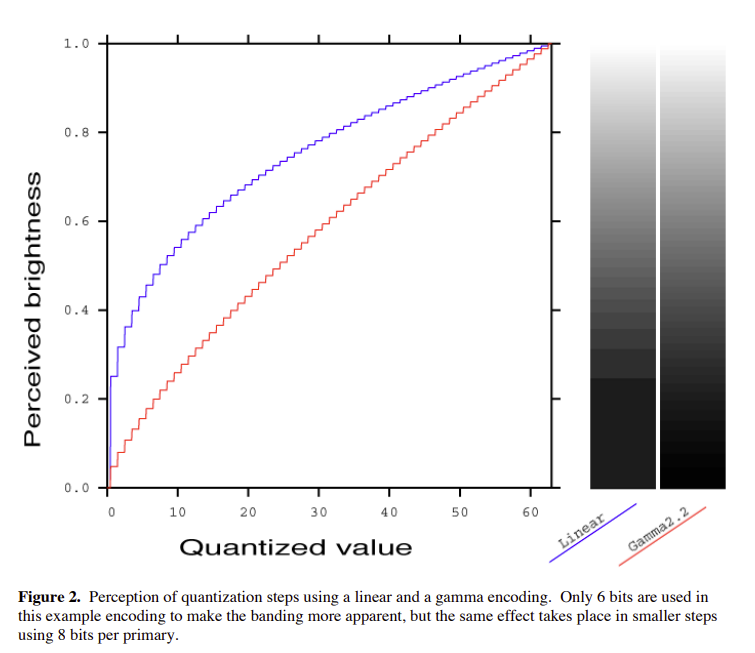
(image from http://www.anyhere.com/gward/hdrenc/hdr_encodings.html)

#### [CIE XYZ](https://en.wikipedia.org/wiki/CIE_1931_color_space#Meaning_of_X,_Y_and_Z) color space
Roughly speaking, CIE XYZ is designed to mimic the way human visual receptors function. Y is equivalent with **luminance**, Z is quasi-equal to blue, or the S cone response, and X is a mix of response curves. An XZ plane at any Y contains *all possible* chromaticities at the luminance Y. CIE XYZ color space is device-invariant, and serves as a standard reference against which other color spaces are defined.   
Since we are concerned about luminance, **CIE Y** value is also important in tone mapping. 

#### Transformation from sRGB to CIE XYZ

,
where linear R(,G,B) is inverse_gamma_correct(R) 

In [25]:
def inv_gamma(color):
    """
    Inverse of sRGB gamma encoding. 
    The gamma curve is often dubbed as power of 2.2 curve,
    but the exact form (to avoid numerical error at the lower end) is linear + power or 2.4.
    """
    conditions=[color <= 0.04045,
                color > 0.04045]
    functions=[lambda color: color/12.92,
              lambda color: ((color+0.055)/1.055)**2.4]
    return np.piecewisec(color, conditions, functions)

def rgb_to_CIEXYZ(rgb):
    transform = np.array([[0.41239080, 0.35758434, 0.18048079],
                          [0.21263901, 0.71516868, 0.07219232],
                          [0.01933082, 0.11919478, 0.95053215]])
    return np.matmul(np.asarray(rgb), transform.T)


def YtoLstar(Y):
    """
    Send this function a luminance value between 0.0 and 1.0,
    and it returns L* which is "perceptual lightness"
    """
    if ( Y <= (216/24389) #       // The CIE standard states 0.008856 but 216/24389 is the intent for 0.008856451679036
        return Y * (24389/27)#  // The CIE standard states 903.3, but 24389/27 is the intent, making 903.296296296296296
    else 
        return Y**(1/3) * 116 - 16
        
(cX, cY, cZ) = rgb_to_CIEXYZ([1,1,1])
print(f"(1,1,1)_rgb is white, or {cY} in CIE Y value.")

(1,1,1)_rgb is white, or 1.00000001 in CIE Y value.


In [45]:
def simple_reinhard(img):
    return img / (1+img)

mapped = simple_reinhard(img)
im2_8bit = np.clip(mapped * 255, 0, 255).astype('uint8')
cv.imwrite("simpleReinhard.png", im2_8bit)

True

(789, 2048, 3)


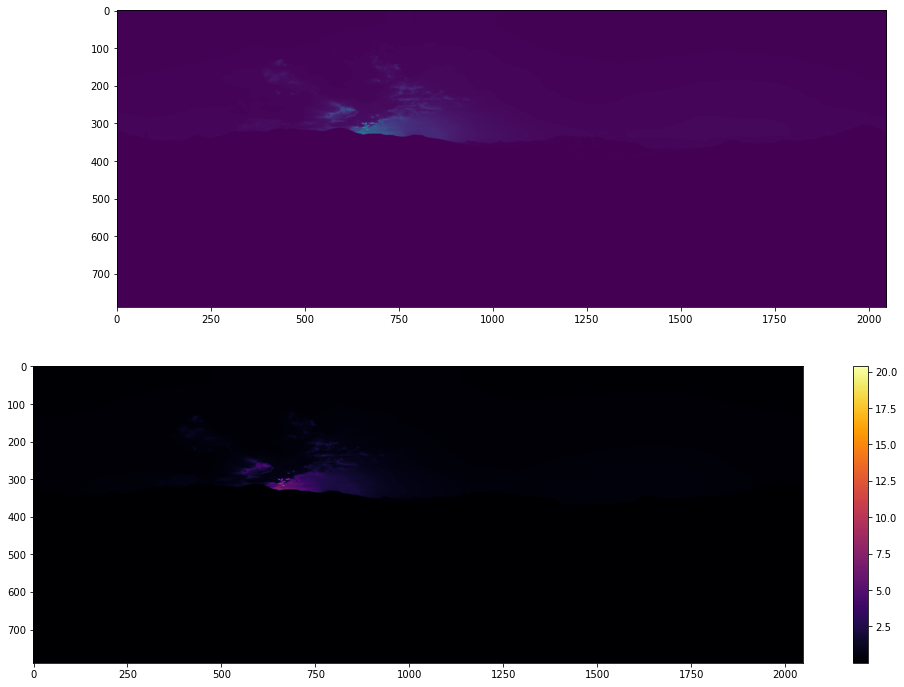

In [63]:
CIE_XYZ = rgb_to_CIEXYZ(img)

print(CIE_XYZ.shape)
# Luminance map
luminance = CIE_XYZ[:,:,1]
fig, axs = plt.subplots(2)
fig.set_size_inches(18,12)
axs[0].set_aspect("equal")
axs[0].imshow(img[:,:,1])
im = axs[1].imshow(luminance, cmap='inferno')
plt.colorbar(im)
plt.show()

In [53]:
def reinhard(img):
    """
    Any pixel above the 'white point' will be saturated.
    """
    white = np.max(img) #-15
    return img*(1+img/white**2) / (1+img)

mapped = reinhard(img)
im2_8bit = np.clip(mapped * 255, 0, 255).astype('uint8')
cv.imwrite("Reinhard.png", im2_8bit)

True